EMアルゴリズムによる混合分布の最適化

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from keras.datasets import mnist
import seaborn as sns
import math
from scipy import stats

In [2]:
# ヘルパー関数の定義
def get_label_idxs(labels: list, t_mnist: np.ndarray) -> np.ndarray:
  label_bool = np.any([t_mnist==label for label in labels], axis=0)
  label_idxs = np.where(label_bool)[0]

  return label_idxs

def transforms(data_all: np.ndarray, flatten=True, binarize=True) -> np.ndarray:
  data_all = data_all.astype(np.float64) / 255
  if flatten:
    data_all = data_all.reshape((data_all.shape[0], -1))
  if binarize:
    data_all = (data_all > 0.5).astype(np.uint8)

  return data_all

In [28]:
NUM_SAMPLES = 60000

(x_mnist, t_mnist), _ = mnist.load_data()
print(f'x_mnist: {x_mnist.shape}, t_mnist: {t_mnist.shape}')

labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

label_idxs = get_label_idxs(labels, t_mnist)

data_all = x_mnist[label_idxs][:NUM_SAMPLES]
print(f'data_all: {data_all.shape}')

binary_data = transforms(data_all)
print(f'binary_data: {binary_data.shape}')

x_mnist: (60000, 28, 28), t_mnist: (60000,)
data_all: (60000, 28, 28)
binary_data: (60000, 784)


In [29]:
# float型では、(大体)1e-323未満の値は精度の問題で0.0となり、
# 対数を取ると -inf となるので下限を抑えておく
def np_log(x):
  return np.log(np.clip(a=x, a_min=1e-323, a_max=1e+10))

# ベルヌーイ分布の対数尤度を計算する関数
def log_bernoulli_density(x, mu):
  log_p = x * np_log(mu) + (1 - x) * np_log(1 - mu)
  log_p = np.sum(log_p)
  return log_p

In [30]:
# 全てのデータ点を用いた、混合ベルヌーイ分布に対する対数尤度を計算する関数
def log_likelihood(binary_data, mu_list, pi_list):
  log_likely_all = 0
  for data in binary_data:
    likely = 0
    for k in range(len(pi_list)):
      likely += pi_list[k] * np.exp(log_bernoulli_density(data, mu_list[k]))
    log_likely_all += np_log(likely)

  return log_likely_all

負担率

負担率は，各データ点が与えられた上での潜在変数(カテゴリ)の事後確率を指します．

負担率を計算することは，各データ点がどのカテゴリからサンプリングされたかを推論することに相当します．

任意のピクセルに対し，$i$番目のデータ(画像)に対する，$k$番目の潜在変数を$z_{ik}$とすると，負担率は以下で表されます．

<!--$$
p_{\mu,\pi}(z_{ik}=1 | {\bf x}_i)
= \frac{p_{{\mu_k},{\pi_k}}({\bf x}_i,z_{ik}=1)}{\sum_{j=1}^K p_{{\mu_j},{\pi_j}}({\bf x}_i, z_{ik}=1)}
=\frac{\pi_k \mu_k^{{\bf x}_i}(1-\mu_k)^{1-{\bf x}_i}}{\sum_{j=1}^K\pi_j \mu_j^{{\bf x}_i}(1-\mu_j)^{1-{\bf x}_i}}
\equiv \gamma(z_{ik})
$$-->

$$
p_{\mu,\pi}(z_{ik}=1 | {\bf x}_i)
= \frac{p_{{\mu},{\pi}}({\bf x}_i,z_{ik}=1)}{\sum_{z} p_{\mu,\pi}({\bf x}_i, z_{ik}=1)}
=\frac{\pi_k\ p_{\mu_k}({\bf x}_i)}{\sum_{j=1}^K\pi_j\ p_{\mu_j}({\bf x}_i)}
\equiv \gamma(z_{ik})
$$

In [31]:
def responsibility(data_all, mu_list, pi_list):
  gamma_mat = np.zeros((data_all.shape[0], len(pi_list)))
  for i in range(gamma_mat.shape[0]):
    for k in range(gamma_mat.shape[1]):
      gamma_mat[i][k] = log_bernoulli_density(data_all[i], mu_list[k])
    gamma_mat[i] -= np.max(gamma_mat[i])
    gamma_mat[i] = pi_list * np.exp(gamma_mat[i])
    gamma_mat[i] /= np.sum(gamma_mat[i])
  return gamma_mat

Iteration: 0, log_likelihood: -736.3872520878632


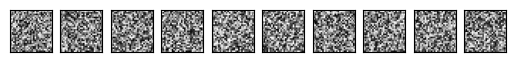

Iteration: 1, log_likelihood: -197.39629233229832
pi_list: [0.001108142480452206, 0.9176979131854757, 0.00425952207210575, 5.749729374523487e-05, 2.702113273710067e-05, 0.00030492235515999105, 0.00886175820692097, 0.0016204119749024094, 0.0018462510071047733, 0.06421656029139594]


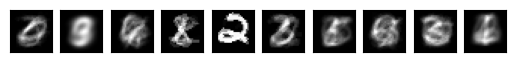

Iteration: 2, log_likelihood: -181.18760033555327
pi_list: [0.036370441793998814, 0.5490606258972935, 0.044209870173419354, 0.000702943364052742, 6.681895134902969e-05, 0.01892947961803707, 0.06433418332457229, 0.06920371657306698, 0.04584229576752733, 0.17127962453668286]


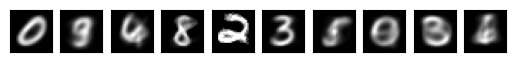

Iteration: 3, log_likelihood: -174.14825240306007
pi_list: [0.05501911208417204, 0.34966801350663435, 0.07371430304480306, 0.011849375644806235, 9.182271693893491e-05, 0.05568598766635721, 0.16964672592600039, 0.07927279246903153, 0.06310923183745108, 0.14194263510380536]


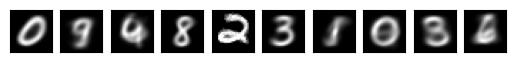

Iteration: 4, log_likelihood: -171.72364480899196
pi_list: [0.061317437400386164, 0.28029426273561303, 0.0909130991362737, 0.038250382275983805, 0.00010000000000000021, 0.07701293550104496, 0.1749902180448663, 0.06734753341496331, 0.0733659256431857, 0.136408205847683]


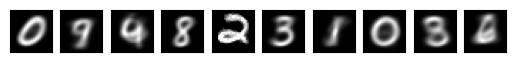

Iteration: 5, log_likelihood: -170.74544507503077
pi_list: [0.06303818035103084, 0.252160912476977, 0.099204438540868, 0.0546590169006703, 0.00010000000000000032, 0.08504489762931854, 0.16630032441923018, 0.058894589076210715, 0.08121036677415044, 0.13938727383154412]


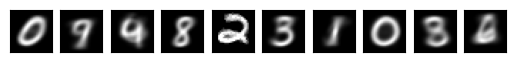

Iteration: 6, log_likelihood: -170.25077735384417
pi_list: [0.06377470072302563, 0.2397046546604891, 0.10301707275658567, 0.06242289281642357, 0.00010000000000000025, 0.0869056095318918, 0.1584939102111952, 0.055301870172579315, 0.087725318746064, 0.14255397038174564]


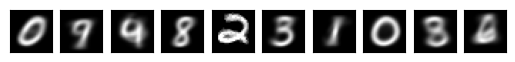

Iteration: 7, log_likelihood: -169.91998504157343
pi_list: [0.06506030731664653, 0.23143586609799527, 0.1053894601752272, 0.06797882982575112, 0.00010000000000000013, 0.08683883468204609, 0.15187789411735286, 0.05418477545248197, 0.09194380706338529, 0.14519022526911365]


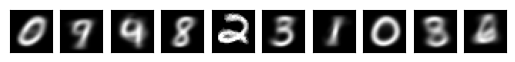

Iteration: 8, log_likelihood: -169.68611271203397
pi_list: [0.06711285104327519, 0.2253487472257656, 0.10665221257165382, 0.07178050909662403, 0.00010000000000000029, 0.08619366021333937, 0.14694702832998796, 0.05423817948618967, 0.09444542498936931, 0.1471813870437951]


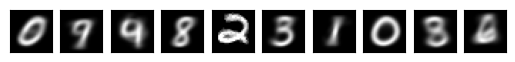

Iteration: 9, log_likelihood: -169.5256405763015
pi_list: [0.06922457952554151, 0.21964633625219518, 0.10855653740236475, 0.07436555832076824, 0.00010000000000000021, 0.08576805237020652, 0.14355216689635716, 0.054968920610191305, 0.0956114723576256, 0.14820637626474972]


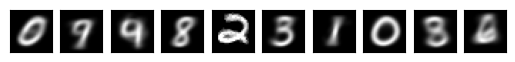

Iteration: 10, log_likelihood: -169.3542344140378
pi_list: [0.0720395238817695, 0.2146562565438687, 0.11020203366133528, 0.07551766996371923, 0.0001000000000000003, 0.0856507252906102, 0.14033637647448705, 0.05594529819488871, 0.09612548812741147, 0.1494266278619099]


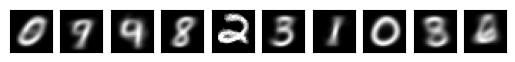

Iteration: 11, log_likelihood: -169.1891511182064
pi_list: [0.07570341091463555, 0.20900842580537443, 0.11240865690345885, 0.07633784811569894, 0.0001000000000000002, 0.08573584958237793, 0.13721426822125585, 0.05712880929694831, 0.09621494645834604, 0.15014778470190407]


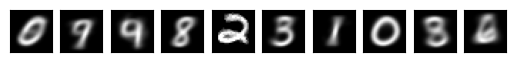

Iteration: 12, log_likelihood: -168.99649894137966
pi_list: [0.07952010539757022, 0.20280990953006878, 0.11401802584898069, 0.07771647407673375, 0.00010000000000000026, 0.0859747944466046, 0.13396921144268084, 0.058626254331048316, 0.09595471977252863, 0.15131050515378422]


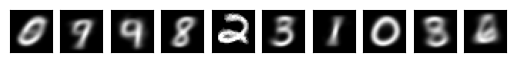

Iteration: 13, log_likelihood: -168.78898986009798
pi_list: [0.08400189608519684, 0.19620634942234902, 0.11551077949191606, 0.07951878892034799, 0.00010000000000000013, 0.08628318755402274, 0.13073410018639559, 0.06004510774907534, 0.0950586565939847, 0.15254113399671188]


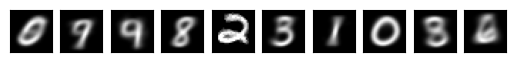

Iteration: 14, log_likelihood: -168.59656715004914
pi_list: [0.08780187882307015, 0.1894151681387777, 0.11684961237399215, 0.08119689134006665, 0.0001000000000000002, 0.08711534403073545, 0.1278842777723889, 0.061764501914773194, 0.09405713504928293, 0.1538151905569127]


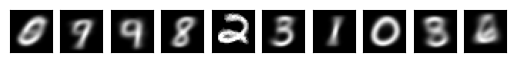

Iteration: 15, log_likelihood: -168.4250200685934
pi_list: [0.09126459873498441, 0.18303140880544552, 0.11818081979557211, 0.08236271655314721, 0.00010000000000000026, 0.08843442405126266, 0.1251858132809887, 0.06343653275992339, 0.09315515936465028, 0.15484852665402582]


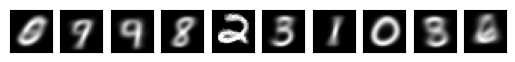

Iteration: 16, log_likelihood: -168.3162253059024
pi_list: [0.09385231055723489, 0.1766651711844814, 0.12029297623463331, 0.08397195989433978, 0.00010000000000000015, 0.08973069221006143, 0.12305967235673755, 0.06533558379256077, 0.09253671025272463, 0.15445492351722614]


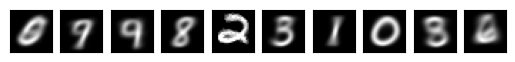

Iteration: 17, log_likelihood: -168.2444782114541
pi_list: [0.09611216249469123, 0.17158339734678107, 0.12258878851243506, 0.08485056658026995, 0.0001000000000000002, 0.09072674304054508, 0.12153283179484006, 0.06697995271116441, 0.09228805255662383, 0.15323750496264926]


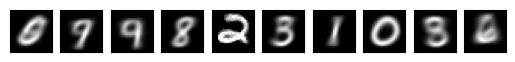

Iteration: 18, log_likelihood: -168.14865856102716
pi_list: [0.09793521740877008, 0.16747948879297897, 0.12508626398100542, 0.08532951932791503, 0.00010000000000000007, 0.09140262777714382, 0.12056403993681869, 0.06834875579761969, 0.09235955604970329, 0.15139453092804495]


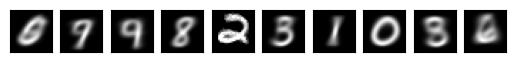

Iteration: 19, log_likelihood: -168.10676113889355
pi_list: [0.09954547457764443, 0.16403066938869035, 0.1275895984535788, 0.08558905743731117, 0.00010000000000000017, 0.09190191555930505, 0.11969479674978767, 0.06948371443531279, 0.09247029358027352, 0.14959447981809626]


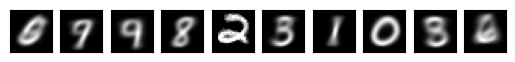

Iteration: 20, log_likelihood: -168.07687972576863
pi_list: [0.10064102256978907, 0.1616568234345608, 0.12933498407456723, 0.0859285286543533, 0.00010000000000000029, 0.09245298679222082, 0.11887211171352657, 0.07050797231918814, 0.092417701182776, 0.14808786925901818]


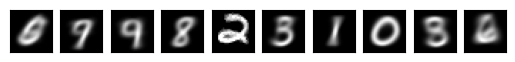

Iteration: 21, log_likelihood: -168.05372623208024
pi_list: [0.1015590866143541, 0.15996738537518945, 0.1306718018445201, 0.0860643347850598, 0.00010000000000000028, 0.09313306658894348, 0.11812647320096134, 0.07125322560882746, 0.09235003386480602, 0.14677459211733834]


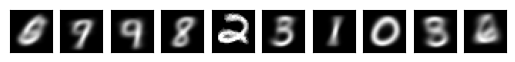

Iteration: 22, log_likelihood: -168.01887466415278
pi_list: [0.10243624843084781, 0.15870534210753923, 0.13171616680240636, 0.08627546531484266, 0.00010000000000000015, 0.09358267056977955, 0.1174130655524622, 0.07174085275030055, 0.09229779034349878, 0.1457323981283229]


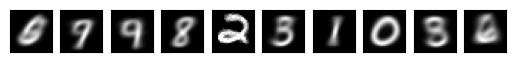

Iteration: 23, log_likelihood: -167.99872512631836
pi_list: [0.10311141880224528, 0.15748737386243078, 0.1325089367058811, 0.08675264787810627, 0.00010000000000000033, 0.09401896566125248, 0.11678990050311006, 0.07219691631230227, 0.09208070852718919, 0.1449531317474826]


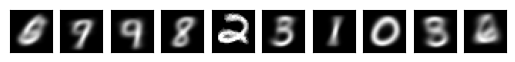

Iteration: 24, log_likelihood: -167.9778686915916
pi_list: [0.10416399777546383, 0.15655614388696495, 0.13315886899170923, 0.08686180384841075, 0.0001000000000000002, 0.09436846565685245, 0.11628737589858262, 0.07260520391806978, 0.09210319787586388, 0.14379494214808264]


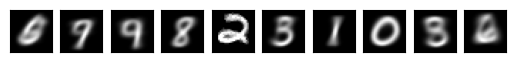

Iteration: 25, log_likelihood: -167.95305535047268
pi_list: [0.10573031470701709, 0.15592172060764137, 0.13366526684019145, 0.08696874294510638, 0.0001000000000000003, 0.09453979745727306, 0.11579448329261548, 0.07289823786184399, 0.09214224852714549, 0.14223918776116573]


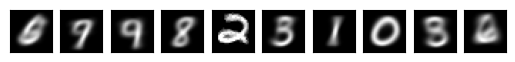

Iteration: 26, log_likelihood: -167.9273560691954
pi_list: [0.10717083040057603, 0.15540458551573144, 0.1341015111449964, 0.08742683635255077, 0.00010000000000000026, 0.09456937493808024, 0.11533325818989569, 0.0730633690769126, 0.0919709864989196, 0.14085924788233734]


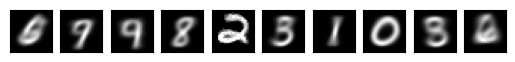

Iteration: 27, log_likelihood: -167.90873546687519
pi_list: [0.10844849703910446, 0.15505491077593597, 0.13446395231413255, 0.08800980923537777, 0.00010000000000000024, 0.09450667813032004, 0.11493916804704, 0.07324629830561005, 0.09189292729824812, 0.13933775885423108]


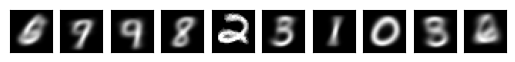

Iteration: 28, log_likelihood: -167.89589758611328
pi_list: [0.10929901002704244, 0.1548396946843508, 0.13486270459462477, 0.08848052770972681, 0.00010000000000000014, 0.09444551284389052, 0.1145652477657735, 0.07340628044276318, 0.09184737794656458, 0.13815364398526347]


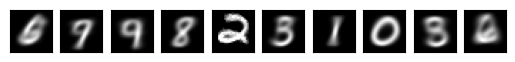

Iteration: 29, log_likelihood: -167.88628894882643
pi_list: [0.110053098291025, 0.15461489940509607, 0.13525558736115126, 0.08865812955957554, 0.00010000000000000018, 0.09460107991967795, 0.11430696642647414, 0.07353904635734117, 0.09177418956446233, 0.13709700311519654]


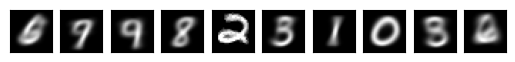

Iteration: 30, log_likelihood: -167.87498379279415
pi_list: [0.11055877783605067, 0.15440935641076972, 0.13563515092529424, 0.08881459586803471, 0.00010000000000000025, 0.09472391676229712, 0.11415073670096268, 0.07364704264338014, 0.09171928505436261, 0.13624113779884817]


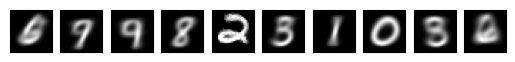

Iteration: 31, log_likelihood: -167.86464833521862
pi_list: [0.11082271225987646, 0.1541701509401277, 0.13602194724759298, 0.08897234246263146, 0.00010000000000000026, 0.09479601149611067, 0.11406796016554448, 0.07374563206536812, 0.09166053533129123, 0.135642708031457]


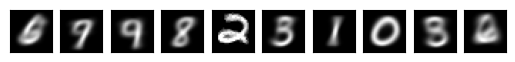

Iteration: 32, log_likelihood: -167.85907863041865
pi_list: [0.11105346858932744, 0.1539776699759445, 0.13625743136058258, 0.08906281890658187, 0.00010000000000000026, 0.09484752261149938, 0.11403178697407212, 0.07375639544919776, 0.09157944848528828, 0.13533345764750604]


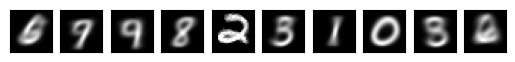

Iteration: 33, log_likelihood: -167.84503384348383
pi_list: [0.111229650362708, 0.15374851753431534, 0.13650007022351945, 0.0891310836740987, 0.00010000000000000022, 0.09488704683347049, 0.11402376482934334, 0.07383271106646026, 0.09156831022666595, 0.1349788452494184]


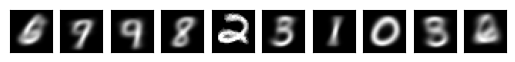

Iteration: 34, log_likelihood: -167.8326313978993
pi_list: [0.11125349333143598, 0.15327680901572152, 0.13673778783679075, 0.08979044751886268, 0.00010000000000000026, 0.09481331886392413, 0.11402279757604676, 0.0739225832414419, 0.09144685077460099, 0.1346359118411752]


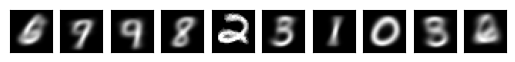

Iteration: 35, log_likelihood: -167.82193724701756
pi_list: [0.11120078351036881, 0.15276140605769709, 0.13695025693211843, 0.09047191704816264, 0.00010000000000000026, 0.09470944460667907, 0.11411023056554866, 0.07400576275242593, 0.09130474261734206, 0.13438545590965736]


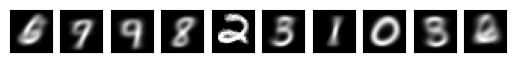

Iteration: 36, log_likelihood: -167.81456465480494
pi_list: [0.11185396734623705, 0.1523032007030272, 0.13719191897156227, 0.09095722940057582, 0.00010000000000000017, 0.09459062128195564, 0.11425633992077669, 0.07407606257905215, 0.09121963577872716, 0.13345102401808603]


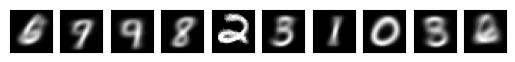

Iteration: 37, log_likelihood: -167.80837285381475
pi_list: [0.1125263761679366, 0.15193615389781795, 0.13740767034394852, 0.09130976458518995, 0.00010000000000000018, 0.09446900306248747, 0.11441831694993387, 0.07414750522057109, 0.09114934253280475, 0.1325358672393098]


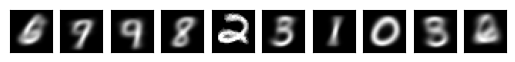

Iteration: 38, log_likelihood: -167.7983219015101
pi_list: [0.1131628618279111, 0.15154677810067788, 0.13760147882011667, 0.09161342566352143, 0.00010000000000000025, 0.09433990645025894, 0.11458110070093142, 0.07420991666066651, 0.09107136344882895, 0.13177316832708716]


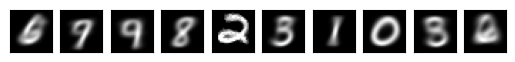

Iteration: 39, log_likelihood: -167.7897942820658
pi_list: [0.1135599438466606, 0.15119102144275115, 0.13777621455642794, 0.09200442649513663, 0.00010000000000000021, 0.09421766514207067, 0.11474655084088523, 0.07425619689024467, 0.09101454230696347, 0.13113343847885958]


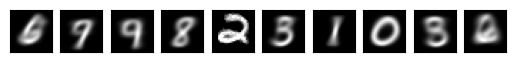

Iteration: 40, log_likelihood: -167.78355597018802
pi_list: [0.11373618868821354, 0.1508661603061878, 0.13795440576665668, 0.0923429041797713, 0.00010000000000000026, 0.09413909194034555, 0.11490481900171362, 0.07428104617447644, 0.0909768292188455, 0.13069855472378944]


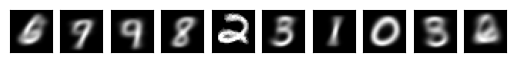

Iteration: 41, log_likelihood: -167.7690896078998
pi_list: [0.11403999764306673, 0.15058862242478474, 0.1380906407026828, 0.09258738421444926, 0.00010000000000000032, 0.09407203954920867, 0.11504933474436654, 0.07429769084004018, 0.09098563528401979, 0.13018865459738133]


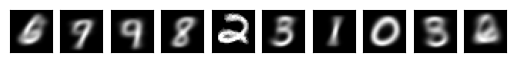

Iteration: 42, log_likelihood: -167.76317009380057
pi_list: [0.11418202916685213, 0.1503237849221399, 0.13822095360231396, 0.09294836355026247, 0.00010000000000000017, 0.09400180502548662, 0.11517191348369085, 0.07435413013607252, 0.09094083318118704, 0.12975618693199448]


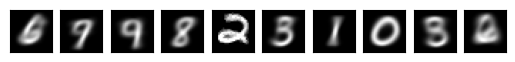

Iteration: 43, log_likelihood: -167.7606058491047
pi_list: [0.11431885391346755, 0.15006922656659644, 0.13834397655638506, 0.09324371447986422, 0.00010000000000000028, 0.09394567434914478, 0.11530614606146271, 0.07441003940587854, 0.09089087677214966, 0.1293714918950509]


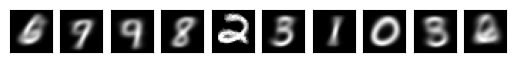

Iteration: 44, log_likelihood: -167.7589970980882
pi_list: [0.11436493953065832, 0.14981537187896868, 0.13845559034082808, 0.09354720446699809, 0.00010000000000000036, 0.09387979523057452, 0.11543006877254748, 0.0744617165203281, 0.09085505784070708, 0.12909025541838964]


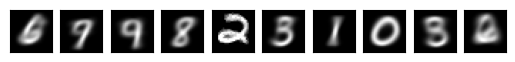

Iteration: 45, log_likelihood: -167.75669867564883
pi_list: [0.11437748596489326, 0.14958600261210644, 0.13855090974073, 0.09380232317548043, 0.00010000000000000015, 0.0937990290174008, 0.11556069032431587, 0.07450783524369155, 0.0908360457626863, 0.12887967815869536]


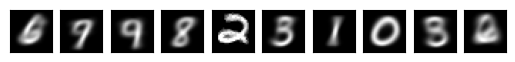

Iteration: 46, log_likelihood: -167.75105157043592
pi_list: [0.11432273747850576, 0.14936400352964266, 0.1386289974897589, 0.09407663243325785, 0.00010000000000000025, 0.09372538379988514, 0.11570036573446502, 0.0745520377454549, 0.09081880983019903, 0.12871103195883069]


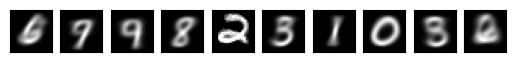

Iteration: 47, log_likelihood: -167.74652856963098
pi_list: [0.11425530053902122, 0.14910751728175806, 0.13867775088014542, 0.09433131210438615, 0.00010000000000000024, 0.09377471230452415, 0.11583890226686927, 0.07459138231009324, 0.09075784936631888, 0.12856527294688375]


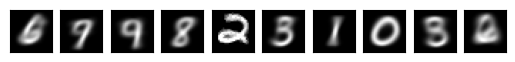

Iteration: 48, log_likelihood: -167.74468186605927
pi_list: [0.1141805300171529, 0.1488819731525696, 0.13871474238460166, 0.09458966563847301, 0.00010000000000000022, 0.09377173094113879, 0.11597598341404321, 0.07463264126281881, 0.09071622522401143, 0.12843650796519065]


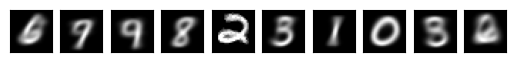

Iteration: 49, log_likelihood: -167.74296056736037
pi_list: [0.114125931657474, 0.14871616878813387, 0.13874216266098205, 0.09475454245985804, 0.00010000000000000025, 0.0937575290475734, 0.11610730976762765, 0.07467119453526175, 0.09069478228865074, 0.12833037879443862]


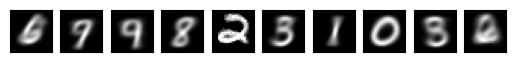

Iteration: 50, log_likelihood: -167.73933829788004
pi_list: [0.1140586534626988, 0.1486140047477858, 0.13877292688733137, 0.0948820174440527, 0.00010000000000000032, 0.09374253867752015, 0.11622627529408698, 0.07470692477624594, 0.09066159483918507, 0.12823506387109315]


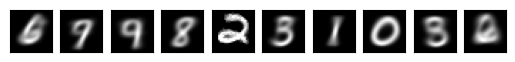

Iteration: 51, log_likelihood: -167.7355904012713
pi_list: [0.11398672358314273, 0.14845070578511452, 0.1387927851829565, 0.09507144597972901, 0.0001000000000000003, 0.09373088804894433, 0.11633899069161534, 0.07474321184438962, 0.09063041867956316, 0.12815483020454477]


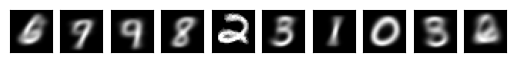

Iteration: 52, log_likelihood: -167.73183898563568
pi_list: [0.11394598333297645, 0.1481245101291589, 0.138815387365047, 0.09537607896350986, 0.00010000000000000025, 0.09371123058917162, 0.11645828971786515, 0.07477940342426687, 0.09061462239384344, 0.12807449408416083]


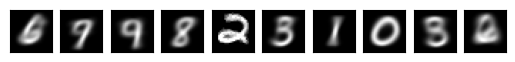

Iteration: 53, log_likelihood: -167.72717595549324
pi_list: [0.11400267183093722, 0.14793906756023756, 0.13881081974909545, 0.09553101723150827, 0.0001000000000000001, 0.09370308461270126, 0.11656978779091758, 0.07481053945480788, 0.09061876400442946, 0.12791424776536545]


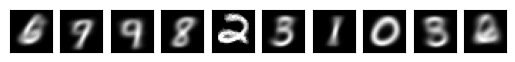

Iteration: 54, log_likelihood: -167.72614778529802
pi_list: [0.11415946578778292, 0.14785693921360563, 0.13880349891638935, 0.09562146930243232, 0.00010000000000000018, 0.09369950589050477, 0.11665969346705317, 0.07484172076877695, 0.0906236541192877, 0.12763405253416713]


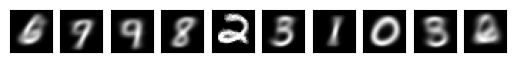

Iteration: 55, log_likelihood: -167.724961990639
pi_list: [0.11423858238597351, 0.14781843777916948, 0.1387944604382383, 0.09568834132170824, 0.00010000000000000029, 0.09369471307707437, 0.11673001751489079, 0.07487185032897399, 0.09062253381562609, 0.12744106333834526]


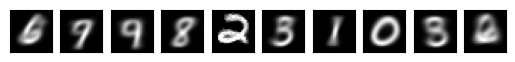

Iteration: 56, log_likelihood: -167.7213892337873
pi_list: [0.11427114031386243, 0.14780008114439186, 0.13875513806677875, 0.09574029079668793, 0.00010000000000000036, 0.09368038258490467, 0.1167864129601051, 0.07489976397583963, 0.09062750223496499, 0.12733928792246452]


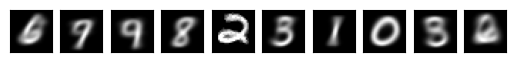

Iteration: 57, log_likelihood: -167.71556361375778
pi_list: [0.11421949624361555, 0.14776473648464192, 0.13873229571041765, 0.09598512952190995, 0.00010000000000000032, 0.09356120410565592, 0.11683288035994879, 0.07493863314870707, 0.09062474934181225, 0.12724087508329107]


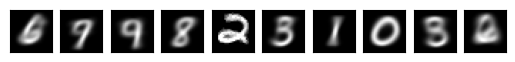

Iteration: 58, log_likelihood: -167.71156067000098
pi_list: [0.11414666202358317, 0.14770409145549154, 0.13873523175050595, 0.0963081780495696, 0.0001000000000000002, 0.0934558572972992, 0.11688476413236222, 0.07496726856239302, 0.09056513006002151, 0.12713281666877377]


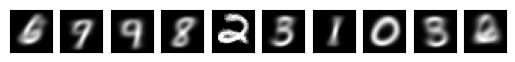

Iteration: 59, log_likelihood: -167.70934185778327
pi_list: [0.11407785645350453, 0.14752331761149395, 0.13872068149378813, 0.09673564885994564, 0.00010000000000000033, 0.09337431383408575, 0.11694598749510252, 0.07496335977735441, 0.09050784234671837, 0.1270509921280067]


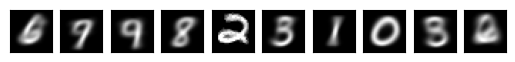

Iteration: 60, log_likelihood: -167.708763860159
pi_list: [0.11400158609456423, 0.14739789595697472, 0.1387110860140391, 0.09705690381131134, 0.00010000000000000029, 0.09330640985800005, 0.1170175172199786, 0.07497863988086947, 0.09046469726674286, 0.1269652638975196]


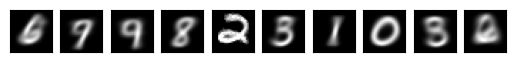

In [32]:
# 各ベルヌーイ分布のパラメータを適当な値で初期化
mu_list = [np.random.rand(binary_data.shape[1]) for _ in labels]

# 混合分布の重みを初期化
pi_list = [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,]

n_iter = 0

# 現在のパラメータを用いて全データに対する対数尤度を計算
likely = log_likelihood(binary_data, mu_list, pi_list) / binary_data.shape[0]
print('Iteration: {0}, log_likelihood: {1}'.format(n_iter, likely))

fig = plt.figure()
for i in range(len(mu_list)):
  ax = fig.add_subplot(1, len(mu_list), i+1, xticks=[], yticks=[])
  ax.imshow(mu_list[i].reshape(28, 28), 'gray')
plt.show()

# 対数尤度の上がり幅がth以下になったら収束したと判断
th = 0.001

# 学習
while True:
  n_iter += 1

  # Eステップ:現在のパラメータのもとでの事後分布(負担率)を計算
  gamma_mat = responsibility(binary_data, mu_list, pi_list)
  n_k = np.sum(gamma_mat, axis=0)

  # Mステップ:負担率を用いて、新しいパラメータを推定・更新
  # piの新しい推定量
  pi_list_next = (n_k / n_k.sum()).tolist()

  # gamma_mat: (2400, 4) binary_data: (2400, 784) n_k: (4, )
  mu_list_next = (binary_data.T @ gamma_mat / n_k).T

  # muの新しい推定量　0次元目だけリストになる
  mu_list_next = list(mu_list_next)

  mu_list = copy.deepcopy(mu_list_next)
  pi_list = copy.deepcopy(pi_list_next)

  likely_before = likely.copy()

  # 対数尤度の再計算
  likely = log_likelihood(binary_data, mu_list, pi_list) / binary_data.shape[0]

  print('Iteration: {0}, log_likelihood: {1}'.format(n_iter, likely))

  delta = likely - likely_before

  print('pi_list: {}'.format(pi_list))

  fig = plt.figure()
  for i in range(len(mu_list)):
    ax = fig.add_subplot(1, len(mu_list), i+1, xticks=[], yticks=[])
    ax.imshow(mu_list[i].reshape(28, 28), 'gray')
  plt.show()

  if delta < th and n_iter > 20:
    break

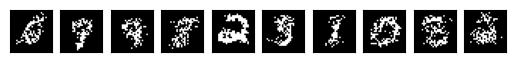

In [33]:
sampled_data = [np.random.binomial(n=1, p=mu) for mu in mu_list]

fig = plt.figure()
for i, sample in enumerate(sampled_data):
  ax = fig.add_subplot(1, len(mu_list), i+1, xticks=[], yticks=[])
  ax.imshow(sample.reshape(28, 28), 'gray')
plt.show()